##TCINet on Nonlinear Synthetic Data
Author: Sahara Ali

In [ ]:
from numpy.random import seed
seed(1)

###Readme:

- Covariate: 2 ->
       'S1 (t)', 'S2 (t)'
- Treatment ->
       'S3 (t)'
- Output Predictand:
       'S4 (t+1)'
- No. of records: 100000
- Look-up window: 1 timestep
- Causal Graph

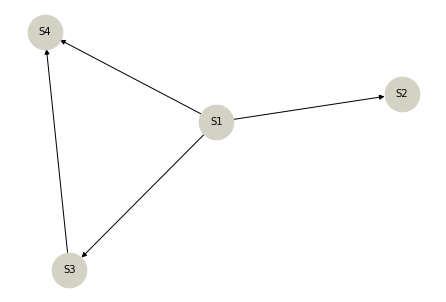

## Initial Setup

In [ ]:
import os
import math
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.compat.v1.keras import backend as K
from keras.layers import Dense, Dropout
from keras.layers import LSTM,TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint

### Loading Combined Data





In [ ]:
df = pd.read_csv('/.../synthetic_data_nonlinear_combined.csv')
df.info()
data = np.array(df)

In [ ]:
target = data[:,3]
cf = data[:,-2:] #factual and counterfactual data
data = data[:,:4]
print(data.shape)
print(cf.shape)
print(target.shape)

(100000, 4)
(100000, 2)
(100000,)


In [ ]:
#Adding a lag to targets
lag = 1

data = data[:-lag,:]
target = target[lag:]

print(data.shape)
print(target.shape)

(99999, 4)
(99999,)


In [ ]:
## Shifting treatment to last column
s3 = data[:,-2].copy()
s3 = s3.reshape(-1,1)
print(s3.shape)
print(data.shape)
data = np.delete(data, -2, 1)
print(data.shape)
data = np.concatenate([data, s3], 1)
print(data.shape)

(99999, 1)
(99999, 4)
(99999, 3)
(99999, 4)


## Train Validation Split

LSTM network expects the input data to be provided with a specific array structure in the form of: [samples, time steps, features]. We load the csv file and only retain the feature and target columns. The features and target are stored in separate np arrays.

In [ ]:
# Sequential split train:val data in 80:20 sequentially

LEN_DATA = len(data) #total number of pixels

NUM_TRAIN = int(LEN_DATA * 0.7)
NUM_VALID = LEN_DATA - NUM_TRAIN

print('LEN_DATA:',LEN_DATA)
print('NUM_TRAIN:',NUM_TRAIN)
print('NUM_VALID:',NUM_VALID)

x_train = data[0:NUM_TRAIN]
x_test = data[NUM_TRAIN:]

#split features and labels
y_train=target[:NUM_TRAIN]
y_test=target[NUM_TRAIN:]

LEN_DATA: 99999
NUM_TRAIN: 69999
NUM_VALID: 30000


## Creating Treated and Untreated versions of Test Data

In [ ]:
treatment = x_test.copy()
treatment = np.delete(treatment, -1, 1)
print(treatment.shape)

ones=np.expand_dims(np.ones(x_test.shape[0]),1)
zeros=np.expand_dims(np.zeros(x_test.shape[0]),1)

x_untreated = np.concatenate([treatment, zeros], 1)
x_treated = np.concatenate([treatment, ones], 1)

(30000, 3)


In [ ]:
print('x_train.shape:',x_train.shape)
print('y_train.shape:',y_train.shape)
print('x_test.shape:',x_test.shape)
print('y_test.shape:',y_test.shape)
print('x_treated.shape:',x_treated.shape)
print('x_untreated.shape:',x_untreated.shape)

x_train.shape: (69999, 4)
y_train.shape: (69999,)
x_test.shape: (30000, 4)
y_test.shape: (30000,)
x_treated.shape: (30000, 4)
x_untreated.shape: (30000, 4)


## Reshaping Input and Target Features

In [ ]:
# convert an array of values into a dataset matrix
def reshape_features(dataset, timesteps=1):
    print(dataset.shape)
    X = dataset.reshape((int(dataset.shape[0]/timesteps)), timesteps, dataset.shape[1])
    return X

## Normalization


In [ ]:
# normalize the features
features = 4
scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,features)) #reshaping to 2d for standard scaling
x_test = scaler_f.transform(x_test.reshape(-1,features)) #reshaping to 2d for standard scaling
x_treated = scaler_f.transform(x_treated.reshape(-1,features)) #reshaping to 2d for standard scaling
x_untreated = scaler_f.transform(x_untreated.reshape(-1,features)) #reshaping to 2d for standard scaling

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,1)) #reshaping to 2d for standard scaling
y_test = scaler_l.transform(y_test.reshape(-1,1)) #reshaping to 2d for standard scaling


In [ ]:
#Reshaping data to 3D for modeling
timesteps = 1
x_train = reshape_features(x_train, timesteps) # reshaping to 3d for model
x_test = reshape_features(x_test, timesteps) # reshaping to 3d for model

x_treated = reshape_features(x_treated, timesteps) # reshaping to 3d for model
x_untreated = reshape_features(x_untreated, timesteps) # reshaping to 3d for model
#test_data = reshape_features(test_data, timesteps) # reshaping to 3d for model

(69999, 4)
(30000, 4)
(30000, 4)
(30000, 4)


In [ ]:
print('x_train.shape:',x_train.shape)
print('y_train.shape:',y_train.shape)
print('x_test.shape:',x_test.shape)
print('y_test.shape:',y_test.shape)
print('x_treated.shape:',x_treated.shape)
print('x_untreated.shape:',x_untreated.shape)

x_train.shape: (69999, 1, 4)
y_train.shape: (69999, 1)
x_test.shape: (30000, 1, 4)
y_test.shape: (30000, 1)
x_treated.shape: (30000, 1, 4)
x_untreated.shape: (30000, 1, 4)


### IPTW Calculation

Inverse Propensity Score Weighted Loss

1. We will first calculate the propensity score of Treatment given covariates using Logistic Regression
2. Then, we will create iptw weights for each Potential outcome Y to weigh their loss with corresponding IPTW weights

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

#Propensity Score Calculation i.e Probability of Treatment given covariates = P(T|X)
tr = x_train.reshape(-1,features)[:,-1]
cov = x_train.reshape(-1,features)[:,:-1]
y = np.zeros_like(tr)
for i in range(len(tr)):
  if tr[i] > tr.mean():
    y[i] = 1
print(tr.shape)
print(cov.shape)
print(y.shape)

(69999,)
(69999, 3)
(69999,)


In [ ]:
model = LogisticRegression().fit(cov, y)
prop_score = model.predict_proba(cov) #probabilities of belonging to a class

In [ ]:
iptw = 1 / prop_score
print(prop_score.shape)
print(iptw.shape)
print(iptw[0,1])

#prop_score has two columns. prop_score[:,1] has probability of treatment being 1, i.e treat > treat.mean().
#Likewise, prop_score[:,0] has probability of treatment being 0, i.e treat < treat.mean()
#We will use these probabilities to calculate IPTW

(69999, 2)
(69999, 2)
2.022219958288061


In [ ]:
# define loss weights using IPTW
iptw_weights = np.ones(len(y_train))
for i in range(len(y_train)):
  if tr[i] > tr.mean():
    iptw_weights[i] = iptw[i,1]
  else:
    iptw_weights[i] = iptw[i,0]

In [ ]:
# We will use the MSE loss function as base loss
loss_fn = tf.keras.losses.MeanSquaredError() #specify the loss

## Building Model

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.losses import Loss
#from attention import Attention

def model(timestep, features, reg_l2):

    x = Input(shape=(timestep,features), name='input')

    # representation
    phi = LSTM(64, return_sequences=True,name='phi_1')(x)
    phi = Dropout(0.2)(phi)
    phi = LSTM(32, return_sequences=True,name='phi_2')(phi)
    #phi = Attention(32)(phi)
    phi = LSTM(32, return_sequences=False,name='phi_3')(phi)
    phi = Dense(units=32, activation='elu', kernel_initializer='RandomNormal',name='phi_4')(phi)
    phi = Dropout(0.2)(phi)

    y0_hidden = Dense(units=16, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y0_hidden_1')(phi)
    y0_hidden = Dense(units=8, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y0_hidden_2')(y0_hidden)
    y0_predictions = Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y0_predictions')(y0_hidden)
    model = Model(inputs=x, outputs=y0_predictions)

    return model

In [ ]:
model=model(1,4, .01)
print(model.summary())

## Compiling the Network and Fitting Model

In [ ]:
from tensorflow.keras.optimizers import SGD

val_split=0.2
batch_size=64
verbose=1
i = 0
tf.random.set_seed(i)
np.random.seed(i)

#optimzier hyperparameters
sgd_lr = 1e-5
momentum = 0.9

#Compiling the network
model.compile(loss=loss_fn, optimizer='adam',sample_weight_mode = 'temporal')
checkpoint_path='./testmodel.h5'
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=60, mode='min', min_delta=0.001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

model.fit(x=x_train,y=y_train,
                validation_split=0.2,
                epochs=200,
                batch_size=batch_size,
                shuffle=True,
                sample_weight=iptw_weights,
                callbacks=keras_callbacks,
                verbose=verbose)

## Causal Effect Estimation

In [ ]:
#Replace S3 with ones for Y(1)
import pandas as pd
import numpy as np

y_pred = model.predict(x_test)
y0_pred=model.predict(x_untreated)
y1_pred=model.predict(x_treated)

938/938 [==============================] - 1s 2ms/step


In [ ]:
#RMSE Model
from sklearn.metrics import mean_squared_error
from math import sqrt

y_pred_f = scaler_l.inverse_transform(y_pred)
y_pred_cf = scaler_l.inverse_transform(y_pred)
y_test = scaler_l.inverse_transform(y_test)

rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.165


In [ ]:
#RMSE Treated
y1_pred = scaler_l.inverse_transform(y1_pred)

rmse = sqrt(mean_squared_error(cf[-30000:,0], y1_pred))
print('Treated RMSE: %.3f' % rmse)

Treated RMSE: 1.017


In [ ]:
#RMSE Untreated
y0_pred= scaler_l.inverse_transform(y0_pred)

rmse = sqrt(mean_squared_error(cf[-30000:,1], y0_pred))
print('Untreated RMSE: %.3f' % rmse)

Untreated RMSE: 1.013


In [ ]:
cate_pred=(y1_pred-y0_pred).squeeze()
cate_true=(cf[-30000:,0]-cf[-30000:,1]).squeeze()

ate_pred=tf.reduce_mean(cate_pred)
ate_true=tf.reduce_mean(cate_true)

print("True ATE:",ate_true.numpy())
print("Estimated ATE:",ate_pred.numpy())

True ATE: -0.5311836093880322
Estimated ATE: -0.53628635


In [ ]:
#PEHE
pehe=tf.reduce_mean( tf.square( ( cate_true - cate_pred) ) )
sqrt_pehe=tf.sqrt(pehe).numpy()
print("\nSQRT PEHE:",sqrt_pehe)


SQRT PEHE: 0.12945024631958996
